***OBJECTIVES 1***

- using training set, calculate recovery for (rougher.output.recovery), find MAE between calculations and actuals
- which features are not available in the test set? what are they? their type?
- perfrom preprocessing, duplicates? missing?, feature scaling

***NOTES***

1. recovery(ROUGHER.output.recovery) = ((rougher.output.concentrate_au * (rougher.input.feed_au - rougher.output.tail_au)) / (rougher.input.feed_au * (rougher.output.concentrate_au - rougher.output.tail_au))) * 100%

2. recovery(FINAL.output.recovery) = ((final.output.concentrate_au * (rougher.output.concentrate_au - final.output.tail_au)) / (rougher.output.concentrate_au * (final.output.concentrate_au - final.output.tail_au))) * 100%

In [1]:
import pandas as pd
import numpy as np

data_full = pd.read_csv('gold_recovery_full.csv')
data_train = pd.read_csv('gold_recovery_train.csv')
data_test = pd.read_csv('gold_recovery_test.csv')

# setting 'date' column to be our new index
data_full = data_full.set_index('date')
data_train = data_train.set_index('date')
data_test = data_test.set_index('date')

# lists of variables used for recovery calculations
rougher_recovery_features = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']
final_recovery_features = ['final.output.concentrate_au', 'rougher.output.concentrate_au', 'final.output.tail_au', 'final.output.recovery']

# displaying non-missing/missing values and their combinations, including percentage as decimal
print(data_train[rougher_recovery_features].isna().value_counts())
print(data_train[rougher_recovery_features].isna().sum())
print(data_train[rougher_recovery_features].isna().sum() / len(data_train))
print()
print(data_train[final_recovery_features].isna().value_counts())
print(data_train[final_recovery_features].isna().sum())
print(data_train[final_recovery_features].isna().sum() / len(data_train))

#print(data_full.info())
#print(data_train.info())
#print(data_test.info())
#print(data_full.isna().sum())
#print(data_train.isna().sum())
#print(data_test.isna().sum())
#print(data_full.sample(20, random_state=777))

rougher.output.concentrate_au  rougher.input.feed_au  rougher.output.tail_au  rougher.output.recovery
False                          False                  False                   False                      14287
                                                      True                    True                        2167
                                                      False                   True                         323
True                           True                   True                    True                          82
False                          True                   False                   True                           1
Name: count, dtype: int64
rougher.output.concentrate_au      82
rougher.input.feed_au              83
rougher.output.tail_au           2249
rougher.output.recovery          2573
dtype: int64
rougher.output.concentrate_au    0.004864
rougher.input.feed_au            0.004923
rougher.output.tail_au           0.133393
rougher.output.recovery   

**- All 3 data sets are missing values "randomly" in almost every column, with ['date'] being the functional index seeing as though none of the datetime columns are missing any values in any of the data sets**

**- Only 2 dtypes across all 3 data sets (object, float64), ['date'] (the only object) will be our index, so there is no need to convert dtypes**

**- There are 2,573 rows we cannot use to validate rougher.output.recovery due to at least one parameter missing, I will be creating a separate df containing only non-missing recovery parameters**

**- There are 1,521 rows that cannot be used to validate final.output.recovery for the same reason as above**

In [2]:
# df containing non-null parameters and output recovery for both rougher and final
calculation_features = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au',
                        'rougher.output.recovery', 'final.output.concentrate_au', 'final.output.tail_au', 'final.output.recovery']
calculation_features_df = data_train[calculation_features].dropna()

# function: rougher output recovery
def rougher_recovery(df):
    C = df['rougher.output.concentrate_au'] # concentrate after flotation
    F = df['rougher.input.feed_au'] # feed before flotation
    T = df['rougher.output.tail_au'] # tail after flotation
    recovery = np.where(F * (C - T) != 0, (C * (F - T)) / (F * (C - T)) * 100, 0)
    return pd.Series(recovery, index=df.index)

# function: final output recovery
def final_recovery(df):
    C = df['final.output.concentrate_au'] # concentrate after purification
    F = df['rougher.output.concentrate_au'] # concentrate after flotation
    T = df['final.output.tail_au'] # tails after purification
    recovery = np.where(F * (C - T) != 0, (C * (F - T)) / (F * (C - T)) * 100, 0)
    return pd.Series(recovery, index=df.index)

# import MAE and verify accuracy of data
from sklearn.metrics import mean_absolute_error as mae

rougher_actual = calculation_features_df['rougher.output.recovery']
rougher_calculated = rougher_recovery(calculation_features_df)

final_actual = calculation_features_df['final.output.recovery']
final_calculated = final_recovery(calculation_features_df)

print('Mean Absolute Error (rougher.output.recovery): ', mae(rougher_actual, rougher_calculated), end=' %\n')
print('Mean Absolute Error (final.output.recovery): ', mae(final_actual, final_calculated), end=' %')

Mean Absolute Error (rougher.output.recovery):  9.317053768151204e-15 %
Mean Absolute Error (final.output.recovery):  25.37306375918405 %

**- With an MAE so close to zero (0.000000000000009317), we can see that the existing data from the warehouse correctly implemented the recovery equation to find output values for rougher.output.recovery**

**- Since I had the framework for validating recovery against rougher.output, I decided to also check the accuracy of final.output.recovery using the equation, and our calculated values are off by an average of 25.4% for all observations. The chosen parameters have yielded the lowest final.recovery MAE for a few combinations, and I believe we should continue with the assumption that the final.output.recovery column in the original data is incorrect. We will be using calculated values instead of the origninal for our target when training to predict final recovery**

In [3]:
# creating sets of column names, subtraction gives us columns not present within the test set
cols_train = set(data_train.columns)
cols_test = set(data_test.columns)
train_unique = cols_train - cols_test

print(train_unique)
print(len(train_unique))

{'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'final.output.tail_pb', 'rougher.output.tail_sol', 'final.output.tail_sol', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_ag', 'rougher.output.tail_ag', 'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'final.output.tail_ag', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.concentrate_pb', 'final.output.concentrate_pb', 'final.output.recovery', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'primary_cleaner.output.tail_sol', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'final.output.tail_au', 'primary_cleaner.output.concentrate_sol', 'secondary_cleaner.output.tail_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'final.output.concentrate_sol', 'secondary_cle

**- The test set is missing 34 features compared to the training and full sets. 30 of them are of the 'output' parameter type, 4 of them are 'calculation'**

**- Next steps:**

**- Merge missing features from data_full back into data_test, matched by index, for future model analysis**

**- Keep rougher.output.recovery target, change final.output.recovery to calculated values for accuracy**

**- Handle missing values accordingly**

Percentage of rows with missing entries: 13.30% test set
Percentage of rows with missing entries: 34.66% train set
Percentage of rows with missing entries: 29.15% full set
Percentage of rows with missing entries: 0.00% test set (after interpolation)
Percentage of rows with missing entries: 0.00% train set (after interpolation)


<Figure size 640x480 with 0 Axes>

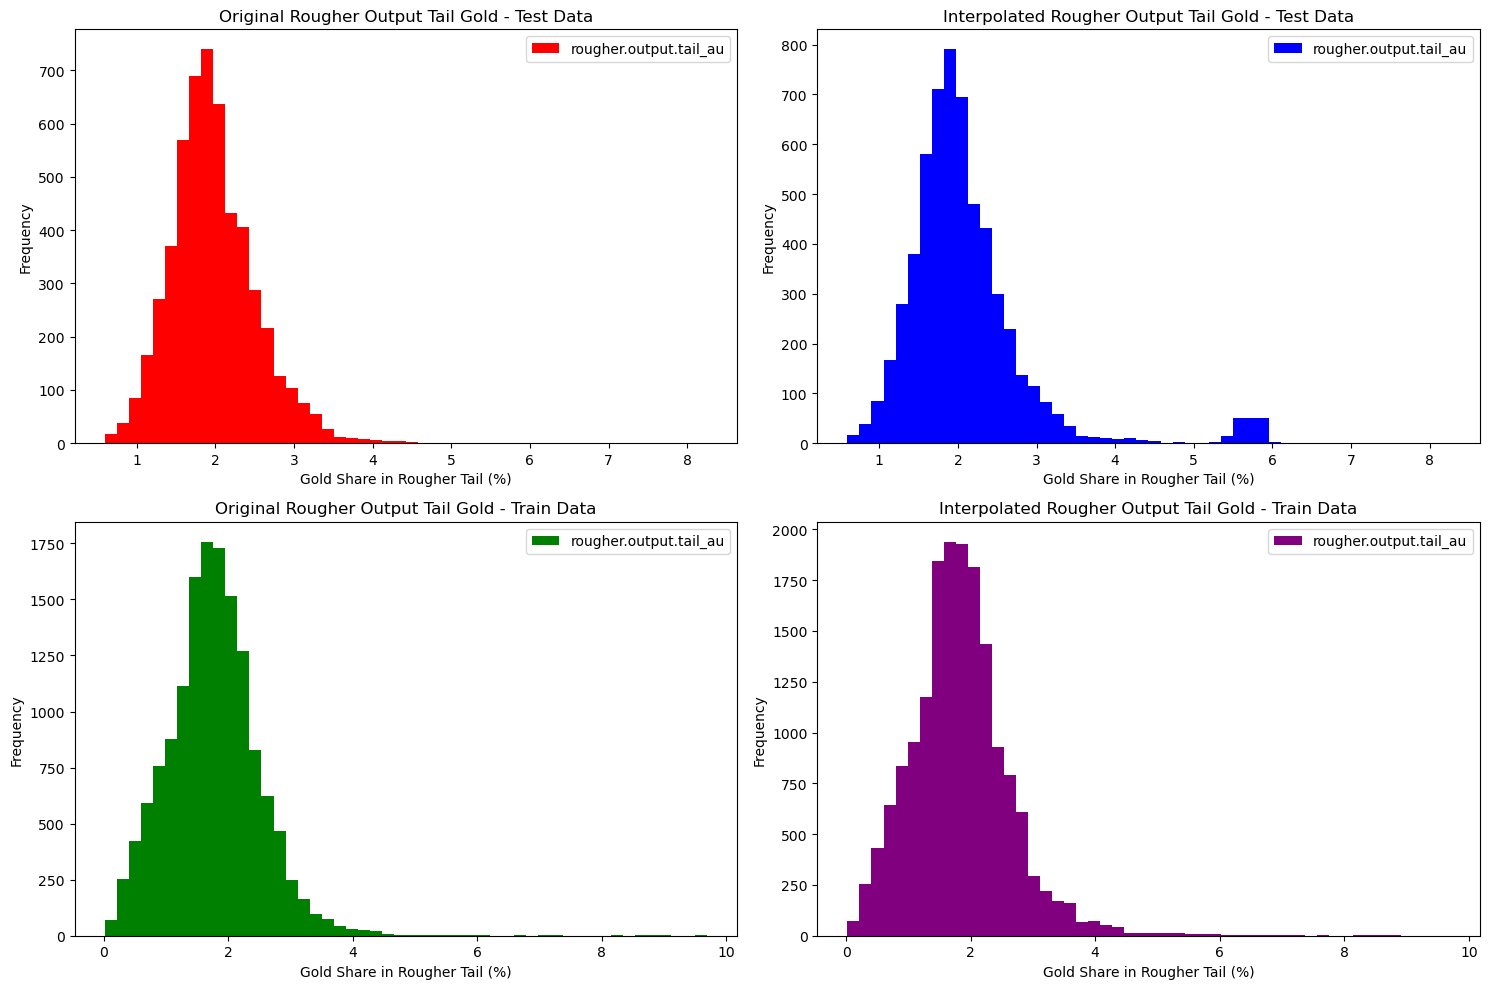

Number of outliers from interpolation within our test set (blue graph):  174
Total entries in observed column within our test set (blue graph):  5856


In [4]:
data_test_refill = data_full.loc[data_test.index]

#print(data_test_clean['secondary_cleaner.state.floatbank4_a_level'].sample(10, random_state=12345))
#print(data_test['secondary_cleaner.state.floatbank4_a_level'].sample(10, random_state=12345))

# function: extract percentage of rows with missing values
def percentage_missing(df):
    rows_nan = df.isnull().any(axis=1).sum()
    total_rows = len(df)
    percentage = (rows_nan / total_rows) * 100
    return f'Percentage of rows with missing entries: {percentage:.2f}%'

print(percentage_missing(data_test_refill), 'test set')
print(percentage_missing(data_train), 'train set')
print(percentage_missing(data_full), 'full set')

# function: handle missing values with interpolation, time based observations, continuous numerical data
def handle_nan(df):
    df_cleaned = df.copy()
    for column in df_cleaned.columns:
        df_cleaned[column] = df_cleaned[column].interpolate(method='linear')
    return df_cleaned

# applying interpolation to both the training and test sets
data_test_cleaned = handle_nan(data_test_refill)
data_train_cleaned = handle_nan(data_train)

print(percentage_missing(data_test_cleaned), 'test set (after interpolation)')
print(percentage_missing(data_train_cleaned), 'train set (after interpolation)')

# analyzing integrity of data after being filled, using column with high missing value frequency
from matplotlib import pyplot as plt

high_frequency_nan = ['rougher.output.tail_au']

plt.figure()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

data_test_refill.plot(kind='hist', y=high_frequency_nan, bins=50, ax=axes[0, 0], xlabel='Gold Share in Rougher Tail (%)', color='red', title='Original Rougher Output Tail Gold - Test Data') # red
data_test_cleaned.plot(kind='hist', y=high_frequency_nan, bins=50, ax=axes[0, 1], xlabel='Gold Share in Rougher Tail (%)', color='blue', title='Interpolated Rougher Output Tail Gold - Test Data') # blue

data_train.plot(kind='hist', y=high_frequency_nan, bins=50, ax=axes[1, 0], xlabel='Gold Share in Rougher Tail (%)', color='green', title='Original Rougher Output Tail Gold - Train Data') # green
data_train_cleaned.plot(kind='hist', y=high_frequency_nan, bins=50, ax=axes[1, 1], xlabel='Gold Share in Rougher Tail (%)', color='purple', title='Interpolated Rougher Output Tail Gold - Train Data') # purple

plt.tight_layout()
plt.show()

print('Number of outliers from interpolation within our test set (blue graph): ', (data_test_cleaned['rougher.output.tail_au'] > 5).sum())
print('Total entries in observed column within our test set (blue graph): ', (data_test_cleaned['rougher.output.tail_au'].count()))

**- I verified that our data was randomly split, by observing index value (date) crossover, rather than split chronologically. This explains the higher percentage of missing values within our training set, more so than the full data set. This explains the initial curiosity I had regarding the logic of our training set missing a higher percentage of values than our full set. If we had 100 coins, and 25 of them were pennies, we'd have 25% pennies. However, if we split the 100 coins randomly into groups of 75 and 25, if all 25 pennies went into the group of 75 (not impossible), our subset of coins would have a higher percentage (33%) of pennies than our original coin collection. I thought of a cool way to understand this logic, and wanted to share.**

**- The 'area under the curve' of our data hardly changed after interpolation, with 174 outliers in a column containing 5856 entries total (2.97% of data). This was a crucial step in ensuring that our data is ready for the steps ahead, with the features of our data sets being filled, I will use the recovery functions to generate target variables for model training purposes when the time comes. The immediate next steps are data analysis in regard to product output (gold, silver, lead) across the different stages of purification.**

<Figure size 640x480 with 0 Axes>

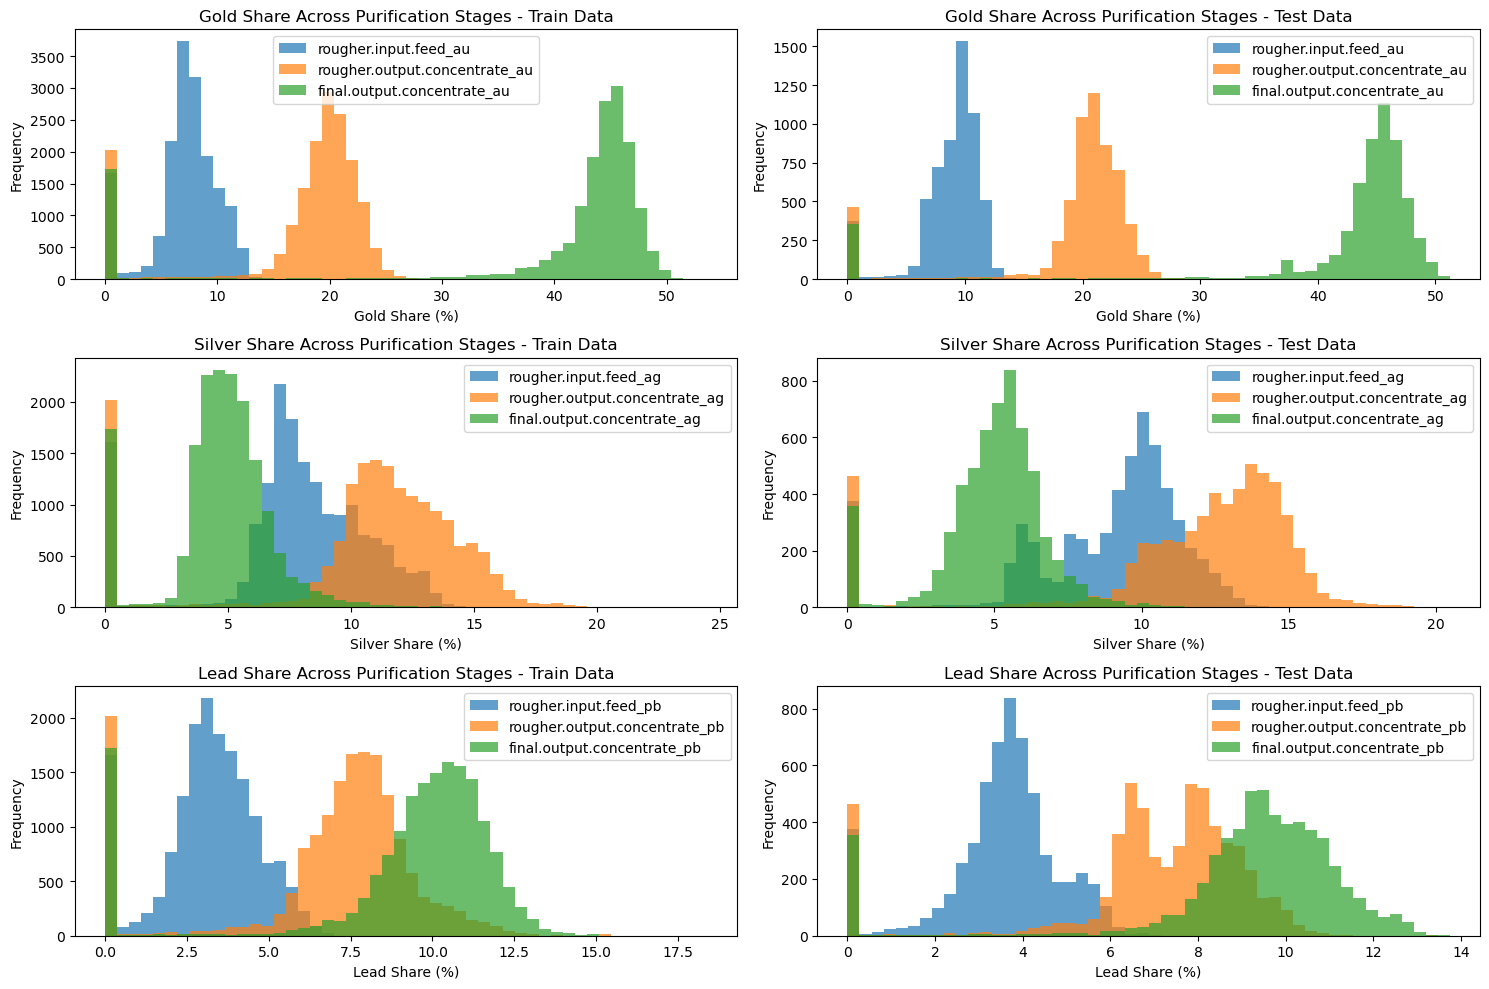

In [5]:
# element concentrates at the 3 main stages of purification; before flotation, after flotation, after purification
gold_concentrate_stages = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'final.output.concentrate_au']
silver_concentrate_stages = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'final.output.concentrate_ag']
lead_concentrate_stages = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'final.output.concentrate_pb']

plt.figure()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

data_train_cleaned.plot(kind='hist', y=gold_concentrate_stages, bins=50, alpha=.7, ax=axes[0, 0], xlabel='Gold Share (%)', title='Gold Share Across Purification Stages - Train Data') # y = gold
data_test_cleaned.plot(kind='hist', y=gold_concentrate_stages, bins=50, alpha=.7, ax=axes[0, 1], xlabel='Gold Share (%)', title='Gold Share Across Purification Stages - Test Data') # y = gold

data_train_cleaned.plot(kind='hist', y=silver_concentrate_stages, bins=50, alpha=.7, ax=axes[1, 0], xlabel='Silver Share (%)', title='Silver Share Across Purification Stages - Train Data') # y = silver
data_test_cleaned.plot(kind='hist', y=silver_concentrate_stages, bins=50, alpha=.7, ax=axes[1, 1], xlabel='Silver Share (%)', title='Silver Share Across Purification Stages - Test Data') # y = silver

data_train_cleaned.plot(kind='hist', y=lead_concentrate_stages, bins=50, alpha=.7, ax=axes[2, 0], xlabel='Lead Share (%)', title='Lead Share Across Purification Stages - Train Data') # y = lead
data_test_cleaned.plot(kind='hist', y=lead_concentrate_stages, bins=50, alpha=.7, ax=axes[2, 1], xlabel='Lead Share (%)', title='Lead Share Across Purification Stages - Test Data') # y = lead

plt.tight_layout()
plt.show()

**- Gold concentrates by stage are consistent between both data sets, with the other elements (silver/lead) seeing noticably different distributions. This difference may introduce unexpected challenges when verifying the accuracy of our model against the test set, since feature distributions will offer an 'unfamiliar environment' from the perspective of our trained model. Considering that the goal is to automate output recovery for gold, silver and lead concentrates are not critical enough to overcome these distribution differences, so it may be worth removing these 2 element concentrates from the data when preparing for model training.**

**- There exist outliers in each step concerning metal concentrate. The zero values may need to be removed, they may not, but it is worth keeping in mind for later.**

<Figure size 640x480 with 0 Axes>

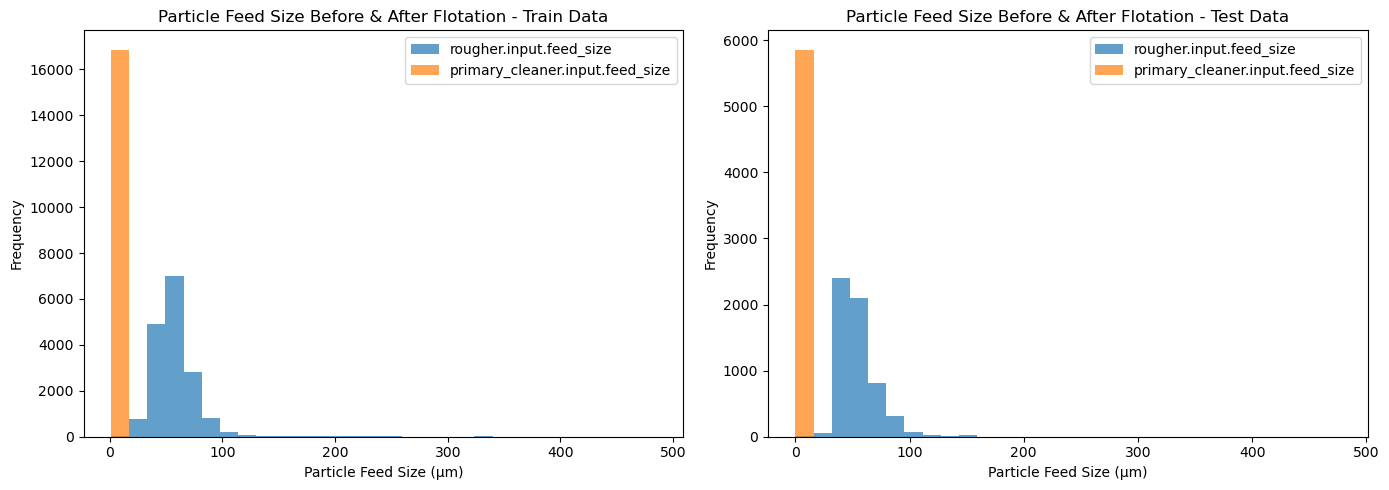

Mean Rougher Input Feed Size: 59.152775718848936 μm (training data)
Mean Primary Cleaner Input Feed Size: 7.297284871257225 μm (training data)

Mean Rougher Input Feed Size: 55.88679974688635 μm (test data)
Mean Primary Cleaner Input Feed Size: 7.2646512922454205 μm (test data)


In [6]:
# particle feed size variable capture
feed_particle_size = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

plt.figure()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

data_train_cleaned.plot(kind='hist', y=feed_particle_size, bins=30, alpha=.7, ax=axes[0], xlabel='Particle Feed Size (μm)', title='Particle Feed Size Before & After Flotation - Train Data') # training data
data_test_cleaned.plot(kind='hist', y=feed_particle_size, bins=30, alpha=.7, ax=axes[1], xlabel='Particle Feed Size (μm)', title='Particle Feed Size Before & After Flotation - Test Data') # test data

plt.tight_layout()
plt.show()

print('Mean Rougher Input Feed Size:', data_train_cleaned['rougher.input.feed_size'].mean(), 'μm (training data)')
print('Mean Primary Cleaner Input Feed Size:', data_train_cleaned['primary_cleaner.input.feed_size'].mean(), 'μm (training data)\n')
print('Mean Rougher Input Feed Size:', data_test_cleaned['rougher.input.feed_size'].mean(), 'μm (test data)')
print('Mean Primary Cleaner Input Feed Size:', data_test_cleaned['primary_cleaner.input.feed_size'].mean(), 'μm (test data)')

**- We have similar particle feed size distributions in both data sets surrounding initial flotation. This shows us that the flotation process effectively grinds larger ore chunks down into much finer particles, and that our data split doesn't compromise this feature as model training material. Averages: (Training Data: 59.15μm - 7.29μm) & (Test Data: 55.88μm - 7.26μm)**

<Figure size 640x480 with 0 Axes>

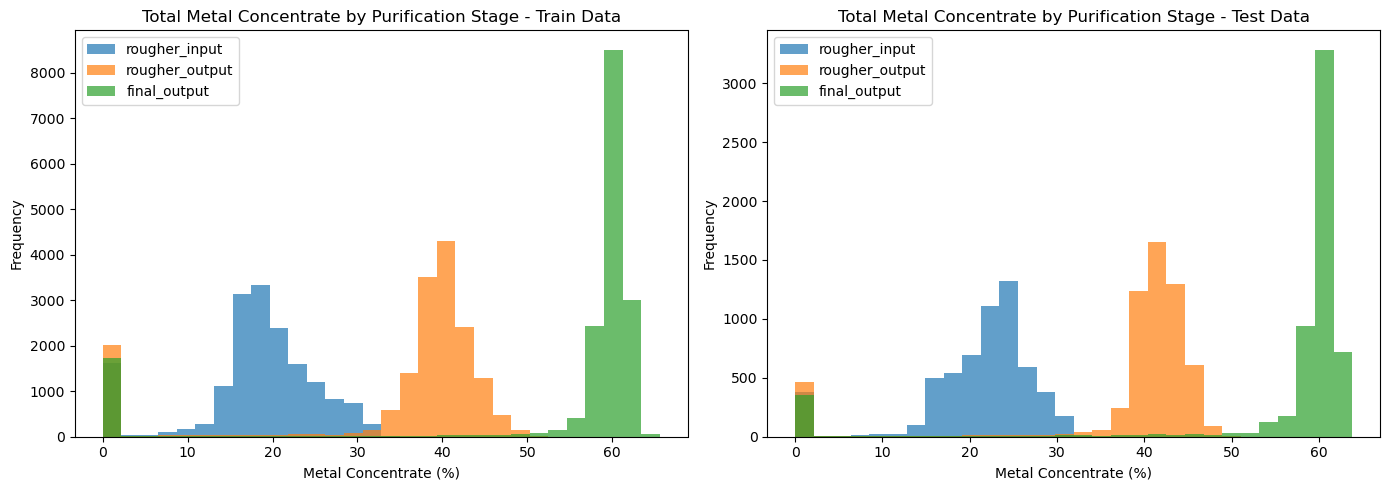

In [7]:
# function: calculate total metal concentrate across purification stages, return plot ready dataframe
def concentrate_totals(df):
    rougher_input = df['rougher.input.feed_au'] + df['rougher.input.feed_ag'] + df['rougher.input.feed_pb']
    rougher_output = df['rougher.output.concentrate_au'] + df['rougher.output.concentrate_ag'] + df['rougher.output.concentrate_pb']
    final_output = df['final.output.concentrate_au'] + df['final.output.concentrate_ag'] + df['final.output.concentrate_pb']
    return pd.DataFrame({'rougher_input': rougher_input, 'rougher_output': rougher_output, 'final_output': final_output})

training_concentrates = concentrate_totals(data_train_cleaned)
test_concentrates = concentrate_totals(data_test_cleaned)

plt.figure()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

training_concentrates.plot(kind='hist', bins=30, alpha=.7, ax=axes[0], xlabel='Metal Concentrate (%)', title='Total Metal Concentrate by Purification Stage - Train Data')
test_concentrates.plot(kind='hist', bins=30, alpha=.7, ax=axes[1], xlabel='Metal Concentrate (%)', title='Total Metal Concentrate by Purification Stage - Test Data')

plt.tight_layout()
plt.show()

**- Our total metal concentrates have roughly the same distributions between both data sets, with a more noticable variation in our rougher_input mean, and an even smaller variation in our rougher_output mean. The zero values make no sense here, some observations saw no metal concentrates in all stages of purification, and will be removed.**

In [8]:
# function: remove entries where total metal concentrate = 0, anomaly handling, return df with original columns only
def remove_anomalies(df):
    df_trimmed = df.copy()
    df_trimmed['rougher_input_total_concentrate'] = df_trimmed['rougher.input.feed_au'] + df_trimmed['rougher.input.feed_ag'] + df_trimmed['rougher.input.feed_pb'] # rougher input
    df_trimmed['rougher_output_total_concentrate'] = df_trimmed['rougher.output.concentrate_au'] + df_trimmed['rougher.output.concentrate_ag'] + df_trimmed['rougher.output.concentrate_pb'] # rougher output
    df_trimmed['final_output_total_concentrate'] = df_trimmed['final.output.concentrate_au'] + df_trimmed['final.output.concentrate_ag'] + df_trimmed['final.output.concentrate_pb'] # final output
    df_trimmed = df_trimmed[(df_trimmed['rougher_input_total_concentrate'] > 0) & (df_trimmed['rougher_output_total_concentrate'] > 0) & (df_trimmed['final_output_total_concentrate'] > 0)] # filter by non-zero
    return df_trimmed.drop(['rougher_input_total_concentrate', 'rougher_output_total_concentrate', 'final_output_total_concentrate'], axis=1) # drop columns created for filtering purposes

# creating new data sets with non zero total concentrates
data_train_ready = remove_anomalies(data_train_cleaned)
data_test_ready = remove_anomalies(data_test_cleaned)

#print(data_train_ready[calculation_features].describe())
#print(data_test_ready[calculation_features].describe())

# function: keep only non-zero calculation parameters
def remove_zero_parameters(df):
    return df[(df['rougher.output.concentrate_au'] > 0) & (df['rougher.input.feed_au'] > 0) & (df['rougher.output.tail_au'] > 0) & (df['rougher.output.tail_au'] > 0) & (df['final.output.tail_au'] > 0)]

# filtering data sets with non-zero calculation parameters
data_train_ready = remove_zero_parameters(data_train_ready)
data_test_ready = remove_zero_parameters(data_test_ready)

#print(data_train_ready[calculation_features].describe())
#print(data_test_ready[calculation_features].describe())

# handling impossible training target values
data_train_ready['rougher.output.recovery'] = rougher_recovery(data_train_ready)
data_train_ready['final.output.recovery'] = final_recovery(data_train_ready)

train_mask = (data_train_ready['rougher.output.recovery'].between(0, 100) & data_train_ready['final.output.recovery'].between(0, 100))
data_train_ready = data_train_ready[train_mask].dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

# handling impossible test target values
data_test_ready['rougher.output.recovery'] = rougher_recovery(data_test_ready)
data_test_ready['final.output.recovery'] = final_recovery(data_test_ready)

test_mask = (data_test_ready['rougher.output.recovery'].between(0, 100) & data_test_ready['final.output.recovery'].between(0, 100))
data_test_ready = data_test_ready[test_mask].dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

#print(data_train_ready[calculation_features].describe())
#print(data_test_ready[calculation_features].describe())

#print(data_train_cleaned.info())
#print(data_train_ready.info())
#print(data_test_cleaned.info())
#print(data_test_ready.info())

**- Anomaly values handled, zero calculation parameters handled, distributions checked, we dropped the provided ['rougher.output.recovery'] & ['final.output.recovery'] from both data sets, and created an entirely new series for the target using our prepared data for the recovery calculations at each observation. This will ensure that our rougher and final recovery values are accurate according to our findings surrounding the Mean Absolute Error, this will give us the best information for feeding our model during training.**

In [9]:
# training set features and targets
data_train_features = data_train_ready.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1) # features
data_train_target_rougher = data_train_ready['rougher.output.recovery'] # rougher
data_train_target_final = data_train_ready['final.output.recovery'] # final

# test set features and targets
data_test_features = data_test_ready.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1) # features
data_test_target_rougher = data_test_ready['rougher.output.recovery'] # rougher
data_test_target_final = data_test_ready['final.output.recovery'] # final

**- Our data has been properly seperated into features and target(s), two targets, one for ['rougher.output.recovery'] and one for ['final.recovery.output']. We will be using these features to predict new targets, and evaluating model performance using our sMAPE function against the predictions with actuals. Cross-Validation will be used during the model evaluation and selection process due to the lack of a validation set, and the projects specific instructions to do so. After a model is selected, we will evaluate performance metrics against the test set for a final score.**

Naive Baseline Final sMAPE (training set): 3.633373456444957 %
Naive Baseline Final sMAPE (test set): 2.843239604302365 %

C:\Users\avonm\AppData\Local\Temp\ipykernel_20444\4286700727.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=target_distribution_check, x='target_n', y='recovery', palette='Set1', fliersize=2)


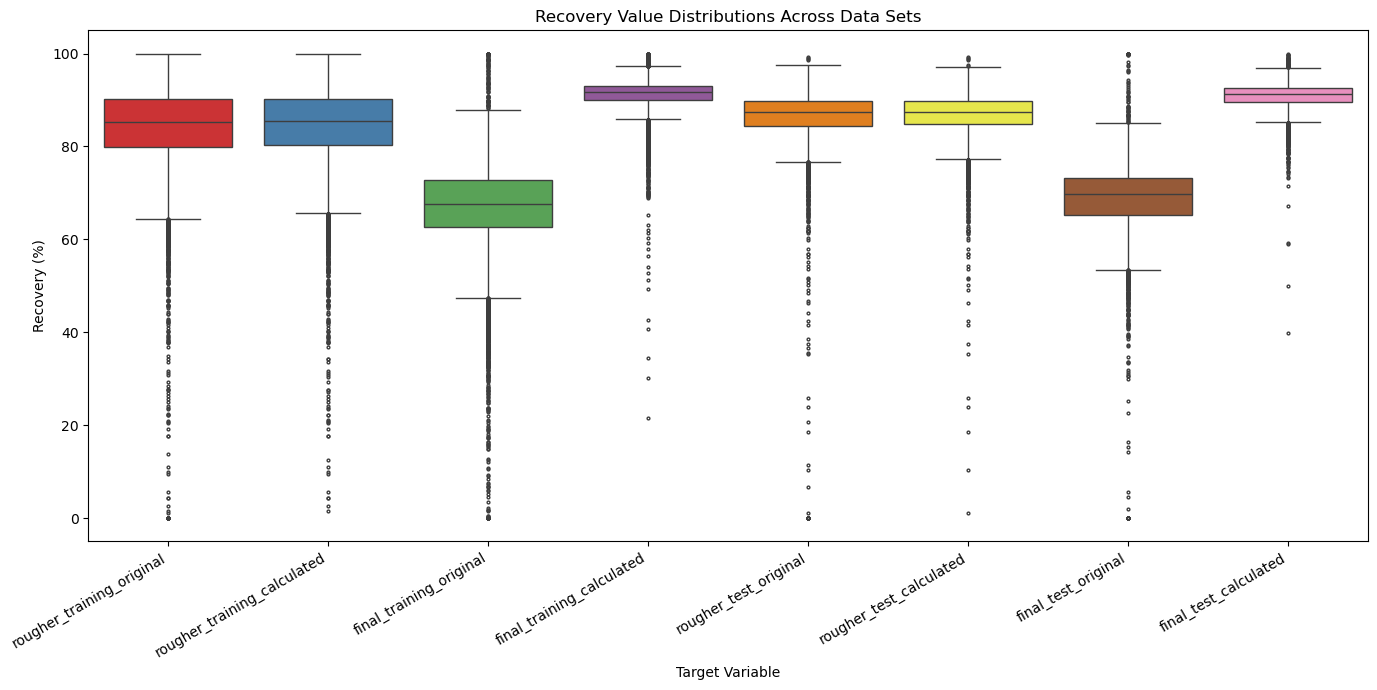

In [10]:
# function: sMAPE
def smape(actual, predicted):
    numerator = np.abs(actual - predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    zero_error = (denominator == 0)
    smape_values = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=~zero_error)
    output = np.mean(smape_values) * 100
    return output

# function: Final sMAPE
def final_smape(smape_rougher, smape_final):
    return (.25 * smape_rougher) + (.75 * smape_final)

# function: baseline naive model smape score
def sanity_smape(target):
    naive_predictions = pd.Series(target.mean(), index=target.index)
    return smape(target, naive_predictions)

# capturing smape of our training targets using actual values and naive predictions (mean for every observation)
baseline_train_smape_rougher = sanity_smape(data_train_target_rougher)
basleine_train_smape_final = sanity_smape(data_train_target_final)
baseline_train_score = final_smape(baseline_train_smape_rougher, basleine_train_smape_final)

print('Naive Baseline Final sMAPE (training set):', baseline_train_score, end=' %\n')

# capturing smape of our test targets using actual values and naive predictions (mean for every observation)
baseline_test_smape_rougher = sanity_smape(data_test_target_rougher)
basleine_test_smape_final = sanity_smape(data_test_target_final)
baseline_test_score = final_smape(baseline_test_smape_rougher, basleine_test_smape_final)

print('Naive Baseline Final sMAPE (test set):', baseline_test_score, end=' %')

#print(data_train_target_final.describe())
#print(data_train['final.output.recovery'].describe())
#print(data_train_target_rougher.describe())
#print(data_train['rougher.output.recovery'].describe())
#print(data_test_target_final.describe())
#print(data_test_refill['final.output.recovery'].describe())
#print(data_test_target_rougher.describe())
#print(data_test_refill['rougher.output.recovery'].describe())

import seaborn as sns

target_distribution_check = pd.DataFrame({'rougher_training_original': data_train['rougher.output.recovery'], 'rougher_training_calculated': data_train_target_rougher,
                                          'final_training_original': data_train['final.output.recovery'], 'final_training_calculated': data_train_target_final,
                                          'rougher_test_original': data_test_refill['rougher.output.recovery'], 'rougher_test_calculated': data_test_target_rougher,
                                          'final_test_original': data_test_refill['final.output.recovery'], 'final_test_calculated': data_test_target_final})
target_distribution_check = target_distribution_check.melt(var_name='target_n', value_name='recovery')

#print(target_distribution_check.info())

plt.figure(figsize=(14, 7))

sns.boxplot(data=target_distribution_check, x='target_n', y='recovery', palette='Set1', fliersize=2)
plt.title('Recovery Value Distributions Across Data Sets')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Target Variable')
plt.ylabel('Recovery (%)')

plt.tight_layout()
plt.show()


**- Before continuing to feature scaling and model evaluation, I felt it was necessary to check the validity of our target variables through all of the changes we have made to ready our data. As expected from earlier when observing the MAE of our recovery functions against the source data, rougher.output.recovery is a reliable source of information. We established that the MAE regarding our final.output.recovery revealed the source data may have been calculated or entered incorrectly, which becomes more apparent now that we can see the distributions of final.output.recovery between source data and calculated target. The Recovery percentage SHOULD be increasing as the process moves from rougher to final output, that is the whole point of it after all. I believe we now have accurate target variables ready for model training.**

In [ ]:
from sklearn.preprocessing import StandardScaler

#print(data_train_features['rougher.output.concentrate_au'].describe())
#print(data_train_features.info())

feature_columns = data_train_features.columns
scaler = StandardScaler()

data_train_scaled = scaler.fit_transform(data_train_features)
data_test_scaled = scaler.transform(data_test_features)

data_train_scaled = pd.DataFrame(data_train_scaled, columns=feature_columns, index=data_train_features.index)
data_test_scaled = pd.DataFrame(data_test_scaled, columns=feature_columns, index=data_test_features.index)


#print(data_train_scaled['rougher.output.concentrate_au'].describe())
#print(data_train_scaled.info())

**- Features are now scaled and ready for model training**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# custom cross-validation function using final smape for scoring, 5 folds
def cross_val_final_smape(model, features, target_rougher, target_final, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=777)
    scores = [] # empty list for score keeping
    for train_index, valid_index in kf.split(features): # for each fold combination...
        features_train, features_valid = features.iloc[train_index], features.iloc[valid_index] # features train, features valid
        target_train_rougher, target_valid_rougher = target_rougher.iloc[train_index], target_rougher.iloc[valid_index] # rougher target train, rougher target valid
        target_train_final, target_valid_final = target_final.iloc[train_index], target_final.iloc[valid_index] # final target train, final target valid

        model.fit(features_train, target_train_rougher) # fit model on training features, rougher target
        predicted_rougher = model.predict(features_valid) # predict valid rougher target
        smape_r = smape(target_valid_rougher, predicted_rougher) # capture smape(rougher) between target and predictions

        model.fit(features_train, target_train_final) # fit model on training features, final target
        predicted_final = model.predict(features_valid) # predict valid final target
        smape_f = smape(target_valid_final, predicted_final) # capture smape(final) between target and predictions

        scores.append(final_smape(smape_r, smape_f)) # calculate final smape for current fold, add to empty list
        return np.mean(scores) # find the mean of our evaluation metric, final smape
    
models = {'LinearRegression': LinearRegression(), 'RandomForest': RandomForestRegressor(random_state=777)}

for name, model in models.items():
    score = cross_val_final_smape(model, data_train_scaled, data_train_target_rougher, data_train_target_final)
    print(f'{name} CV Final sMAPE: {score:.3f} %')

LinearRegression CV Final sMAPE: 0.969 %
RandomForest CV Final sMAPE: 0.339 %


**- Naive Model Baseline Final sMAPE (training set): 3.633 %**

**- LinearRegression CV Final sMAPE: 0.969 %**

**- RandomForest CV Final sMAPE: 0.339 %**

**- Both of our trained models absolutely crushed the naive model (mean for every observation, Final sMAPE: 3.633%), however the RandomForestRegressor model performed substantially better than LinearRegression (Final sMAPE: 0.339% vs 0.969%)**

**- We will be moving to the final step of evaluating our model against the test set**

In [16]:
model = RandomForestRegressor(random_state=777)

model.fit(data_train_scaled, data_train_target_rougher)
predicted_rougher = model.predict(data_test_scaled)
smape_r = smape(data_test_target_rougher, predicted_rougher)

model.fit(data_train_scaled, data_train_target_final)
predicted_final = model.predict(data_test_scaled)
smape_f = smape(data_test_target_final, predicted_final)

print(f'RandomForest Final sMAPE: {final_smape(smape_r, smape_f):.3f} %')

RandomForest Final sMAPE: 0.363 %


**- Best Model: RandomForestRegressor(random_state=777)**

**- RandomForest Final sMAPE: 0.363 %**

**- Our model has successfuly predicted rougher and final output recovery values, and passed the performance check with flying colors (0.363%) utilizing the Final sMAPE function.**

**------ Remarkable Observations ------**

**1. Source data contained incorrect values for final.output.recovery, the final recovery percentages should be higher than rougher recovery, which we fixed by applying the correct recovery function in order to create accurate target variables**

**2. Our test set was missing 34 columns before index matching to re-attached them, this gave us a full test set with all variables required for future calculations**

**3. Total metal concentrate, and variables used for calculation all contained entries with zero values within their columns, causing chaos for our recovery function. These were handled accordingly, and allowed us to have clean, ready data for model training**

**4. We established a baseline naive model Final sMAPE of 3.633% for our training data, which served as a benchmark for determining if our trained models were performing better than assuming the mean for every recovery observation**

**5. Our model scored a Final sMAPE of 0.339% in the cross-validation metric test, and a Final sMAPE of 0.363% against the new, unseen test set. This tells us that our model can accurately predict output recovery percentages, AS LONG AS THERE ARE NO IMPOSSIBLE NUMBERS! (zeroes, over 100)**

**------ Personal Note ------**

**This project was extremely difficult, and frustrating at times, but it was more fun than anything else. Hopefully I did this right, but the code is modular enough to make easy changes if not approved, thank you for taking the time to grade this.**